In [10]:
%pip install scikit-image
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
import numpy as np

csv_path = "problems\problems\isolated.csv"
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs


<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Dell\AppData\Local\Temp\ipykernel_18060\975571372.py:3: SyntaxWarning: invalid escape sequence '\p'
  csv_path = "problems\problems\isolated.csv"


In [20]:
path_XYs = read_csv(csv_path)

In [21]:
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

In [22]:
import matplotlib.pyplot as plt
def plot(path_XYs ):
    fig, ax = plt.subplots(tight_layout=True , figsize =(8, 8))
    for i, XYs in enumerate(path_XYs ):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth =2)
    ax.set_aspect('equal')
    plt.show()

Matplotlib is building the font cache; this may take a moment.


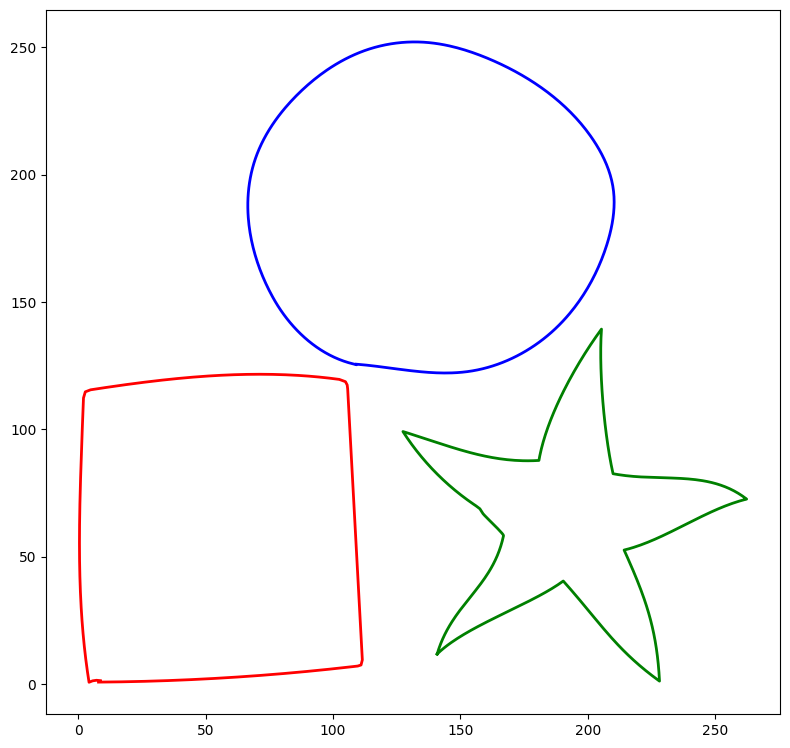

In [23]:
plot(path_XYs)

In [24]:
from scipy.spatial import ConvexHull
import numpy as np

def is_straight_line(XY):
    # Check if points are collinear
    if len(XY) < 2:
        return False
    diffs = np.diff(XY, axis=0)
    return np.all(np.abs(diffs - diffs[0]) < 1e-5)

def is_circle(XY, tolerance=10):
    # Check if points lie on a circle
    if len(XY) < 3:
        return False
    center = np.mean(XY, axis=0)
    radius = np.linalg.norm(XY[0] - center)
    distances = np.linalg.norm(XY - center, axis=1)
    return np.all(np.isclose(distances, distances[0], atol=tolerance))

def is_ellipse(XY):
    # Use an ellipse fitting algorithm to determine if the shape is an ellipse
    from skimage.measure import EllipseModel
    if len(XY) < 5:
        return False
    try:
        ellipse = EllipseModel()
        ellipse.estimate(XY)
        return True
    except:
        return False

def is_rectangle(XY, angle_tolerance=30):
    # Check if points form a quadrilateral
    if len(XY) < 4:
        return False
    
    hull = ConvexHull(XY)
    hull_points = XY[hull.vertices]
    if len(hull_points) != 6:
        return False
    
    # Calculate the angles between consecutive edges
    def angle_between(v1, v2):
        cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        theta = np.arccos(np.clip(cos_theta, -1.0, 1.0))
        return np.degrees(theta)
    angles = []
    for i in range(4):
        v1 = hull_points[i] - hull_points[i-1]
        v2 = hull_points[(i+1) % 4] - hull_points[i]
        angle = angle_between(v1, v2)
        angles.append(angle)
        
    
    return True

def is_rounded_rectangle(XY):
    # Check for rectangles with rounded corners
    if is_rectangle(XY):
        # Further check if corners are rounded
        return True
    return False

def is_regular_polygon(XY):
    # Check if the shape is a regular polygon
    if len(XY) < 3:
        return False
    distances = np.linalg.norm(np.diff(XY, axis=0, append=XY[:1]), axis=1)
    angles = np.arctan2(np.diff(XY[:, 1]), np.diff(XY[:, 0]))
    angle_diffs = np.diff(np.concatenate([angles, [angles[0]]]))
    return np.all(np.abs(distances - distances[0]) < 1e-2) and np.all(np.abs(angle_diffs) < 1e-2)

def is_star_shape(XY):
    # Check if the shape is a star by looking for radial symmetry
    # This is more complex and may require more advanced techniques
    return False  # Placeholder


In [26]:
def regularize_circle(XY):
    center = np.mean(XY, axis=0)
    radius = np.mean(np.linalg.norm(XY - center, axis=1))
    angles = np.linspace(0, 2 * np.pi, 100)
    return center + radius * np.column_stack([np.cos(angles), np.sin(angles)])

def regularize_rectangle(XY):
    hull = ConvexHull(XY)
    return np.array([XY[i] for i in hull.vertices[:2]])

def regularize_polygon(XY):
    # Assuming it's a regular polygon
    return XY  # Placeholder, needs proper regularization

def regularize_ellipse(XY):
    # Assuming it's a regular polygon
    return XY  # Placeholder, needs proper regularization

def regularize_star(XY):
    return XY

hello_circle
hello_rectangle


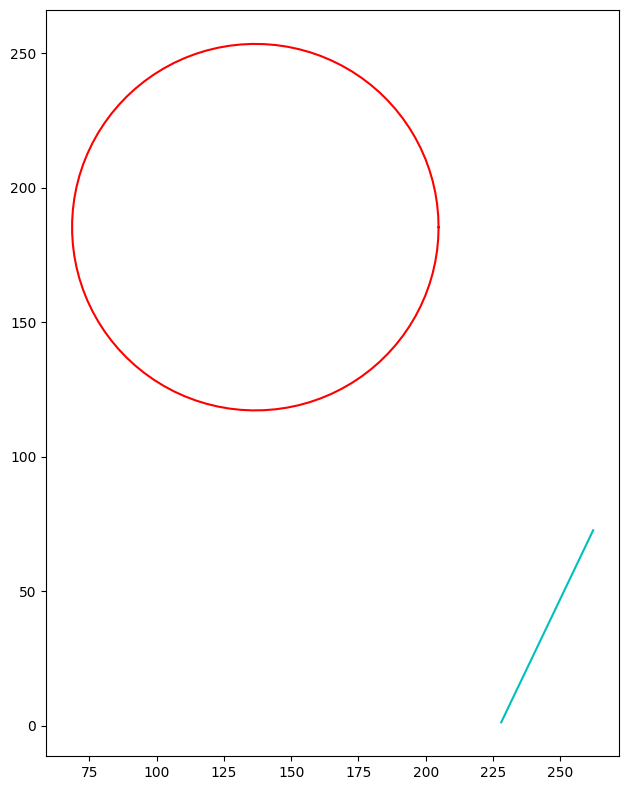

In [27]:
import matplotlib.pyplot as plt
def plot_shapes(path_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    
    for i, shape in enumerate(path_XYs):
        for path in shape:
            if i != 2:
                if is_straight_line(path):
                    print("hello_line")
                    ax.plot(path[:, 0], path[:, 1], 'b', label='Straight Line')
                elif is_circle(path):
                    print("hello_circle")
                    ax.plot(*regularize_circle(path).T, 'r', label='Circle')
                # elif is_ellipse(path):
                #     print("hello_ellipse")
                #     ax.plot(*regularize_ellipse(path).T, 'g', label='Ellipse')
                elif is_rectangle(path,i):
                    print("hello_rectangle")
                    ax.plot(*regularize_rectangle(path).T, 'c', label='Rectangle')
                # elif is_regular_polygon(path):
                #     print("hello_polygon")
                #     ax.plot(*regularize_polygon(path).T, 'm', label='Polygon')
                # elif is_star_shape(path):
                #     print("hello_star")
                #     ax.plot(*regularize_star(path).T, 'y', label='Star')
    
    ax.set_aspect('equal')
    plt.show()

plot_shapes(path_XYs)
